#### Database

In [1]:
PROJECT_PATH = '/home/md/Work/ligalytics/leagues_stable/'
import os, sys
sys.path.insert(0, PROJECT_PATH)
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "leagues.settings")

from leagues import settings
settings.DATABASES['default']['NAME'] = PROJECT_PATH+'/db.sqlite3'

import django
django.setup()

from scheduler.models import *
from common.functions import distanceInKmByGPS
season = Season.objects.filter(nicename="Imported: Benchmark Season").first()
import pandas as pd
import numpy as np
from django.db.models import F
games = Game.objects.filter(season=season)
df = pd.DataFrame.from_records(games.values())
games = Game.objects.filter(season=season).annotate(
    home=F('homeTeam__shortname'),
    away=F('awayTeam__shortname'),
    home_lat=F('homeTeam__latitude'),
    home_lon=F('homeTeam__longitude'),
    home_attr=F('homeTeam__attractivity'),
    away_lat=F('awayTeam__latitude'),
    away_lon=F('awayTeam__longitude'),
    away_attr=F('awayTeam__attractivity'),
    home_country=F('homeTeam__country'),
    away_country=F('awayTeam__country'),
).values()



#### Dataframe

In [31]:
from sklearn.preprocessing import OneHotEncoder

# create dataset
df = pd.DataFrame.from_records(games.values())

# data cleaning
df['time'] = df['time'].replace('','0')
df = df[df['attendance'] != 0]

# remove outliers
out_fields = ['attendance']
for field in out_fields:
    q_low = df[field].quantile(0.01)
    q_hi  = df[field].quantile(0.99)
    df = df[(df[field] < q_hi) & (df[field] > q_low)]


# pivots
pivot_homeTeam_mean = df.pivot_table('attendance','homeTeam_id',aggfunc='mean')
pivot_homeTeam_max = df.pivot_table('attendance','homeTeam_id',aggfunc='max')

# add more features
df['weekday'] = df.apply(lambda r: r['date'].weekday(), axis=1)
df['day'] = df.apply(lambda r: r['date'].day, axis=1)
df['month'] = df.apply(lambda r: r['date'].month, axis=1)
df['year'] = df.apply(lambda r: r['date'].year, axis=1)
df['distance'] = df.apply(lambda r: distanceInKmByGPS(r['home_lon'],r['home_lat'],r['away_lon'],r['away_lat']), axis=1)
df['weekend'] = df.apply(lambda r: int(r['weekday'] in [6,7]), axis=1)
df['winter_season'] = df.apply(lambda r: int(r['month'] in [1,2,3,10,11,12]), axis=1)
df['home_base'] = df.apply(lambda r: pivot_homeTeam_mean.loc[r['homeTeam_id'],'attendance'], axis=1)
df['stadium_size'] = df.apply(lambda r: pivot_homeTeam_max.loc[r['homeTeam_id'],'attendance'], axis=1)
df['early'] = df.apply(lambda r: r['time'].replace(':','') < "1800", axis=1)
df['before2010'] = df.apply(lambda r: r['historic_season'].split('-')[0] < "2010", axis=1)



# one hot encoding
ohe_fields = ['home_country']

for field in ohe_fields:
    ohe = OneHotEncoder()
    transformed = ohe.fit_transform(df[[field]])
    df[ohe.categories_[0]] = transformed.toarray()

# sort label to last index
cols = list(df.columns)
cols.append(cols.pop(cols.index('attendance')))
df = df[cols]

#### Train/Test Data - Normalization

In [32]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor


remove_columns = ['season_id', 'resultEntered', 'reversible', 'reschedule', 'homeGoals', 'awayGoals',
                  'homeGoals2', 'awayGoals2', 'homeGoals3', 'awayGoals3', 'home', 'away', 'date', 'time',
                  'id', 'homeTeam_id', 'awayTeam_id', 'historic_season',
                  'home_country','home_lat','home_lon','away_lat','away_lon','away_country','year']
feature_cols = list(set(df.columns[:-1]) - set(remove_columns))
# feature_cols = ['weekday','weekend','home_base','distance','winter_season']
label = 'attendance'


data = df[feature_cols+[label]]




X = df[feature_cols]  # Features
y = df[label]  # Target variable

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1)  # 70% training and 30% test

In [60]:
rf_regressor = RandomForestRegressor(n_estimators = 200 ,  random_state = 42)
rf_regressor.fit(X_train,y_train)

# #Predicting the SalePrices using test set 
y_pred_rf = rf_regressor.predict(X_test)

# #Random Forest Regression Accuracy with test set
print('Random Forest Regression Accuracy: ', rf_regressor.score(X_test,y_test))

# #Predicting the SalePrice using cross validation (KFold method)
# y_pred_rf = cross_val_predict(rf_regressor, X, y, cv=10 )

# #Random Forest Regression Accuracy with cross validation
# accuracy_rf = metrics.r2_score(y, y_pred_rf)
# print('Cross-Predicted(KFold) Random Forest Regression Accuracy: ', accuracy_rf)

Random Forest Regression Accuracy:  0.701779484610914


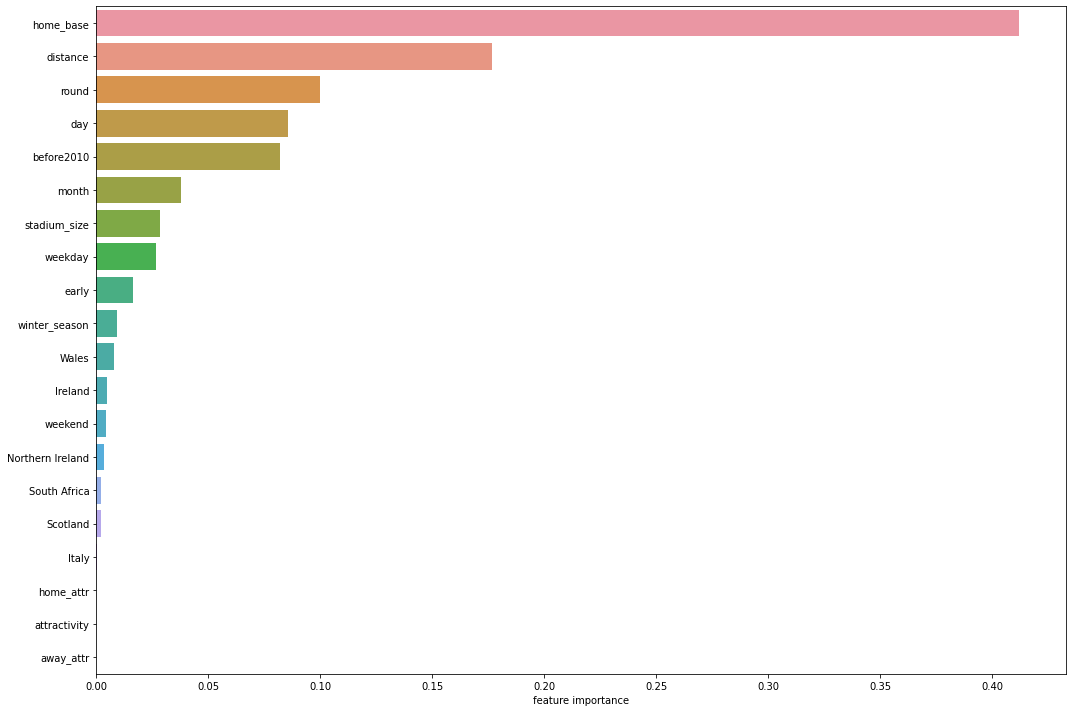

In [43]:
ranking = np.argsort(-rf_regressor.feature_importances_)
f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x=rf_regressor.feature_importances_[ranking], y=X_train.columns.values[ranking], orient='h')
ax.set_xlabel("feature importance")
plt.tight_layout()
plt.show()

In [61]:
for i,v in enumerate(y):
    print(i,v,y_pred_rf[i])

0 4000 6580.545
1 3264 1930.28
2 6000 4557.7
3 4250 5707.365
4 1200 2293.235
5 4300 14245.4
6 3874 10814.615
7 2800 7051.27
8 5500 5780.415
9 6000 16578.36
10 3500 3465.88
11 4500 6437.125
12 2140 2539.445
13 3146 7725.725
14 2600 4115.015
15 4875 3892.94
16 5807 2310.32
17 5200 5284.785
18 3500 14448.53
19 2643 13368.715
20 4000 5098.405
21 2500 11200.69
22 2000 4440.93
23 3198 13613.71
24 3571 2143.51
25 2712 14239.07
26 2100 2803.565
27 4525 3025.8
28 6625 5005.1
29 4966 4908.325
30 2000 11584.62
31 2100 17840.985
32 2310 11679.06
33 2600 3441.75
34 2000 4676.61
35 4300 12716.24
36 2734 4625.195
37 3500 8200.89
38 3050 5654.81
39 5256 9792.665
40 3012 2310.83
41 5060 4974.58
42 1500 9684.55
43 4000 7074.835
44 1950 9311.275
45 2300 5989.395
46 2300 2172.745
47 1950 9854.69
48 3058 3366.505
49 2000 9185.505
50 2345 5486.87
51 5500 6112.29
52 5585 3817.555
53 4046 5211.04
54 6000 5262.485
55 4384 4752.54
56 3000 4680.4
57 3500 3730.125
58 7000 19604.555
59 10195 12155.54
60 3476 2316.

IndexError: index 652 is out of bounds for axis 0 with size 652